In [32]:
import os
import cv2
import numpy as np
import sys
import pickle
from optparse import OptionParser
import time
from keras_frcnn import config
import keras_frcnn.resnet as nn
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras_frcnn import roi_helpers
import random
from keras.utils import plot_model
import pydot
from IPython import display

%matplotlib inline


sys.setrecursionlimit(40000)
		
# parser = OptionParser()

# parser.add_option("-p", "--path", dest="test_path", help="Path to test data.")
# parser.add_option("-n", "--num_rois", dest="num_rois",
# 				help="Number of ROIs per iteration. Higher means more memory use.", default=32)
# parser.add_option("--output_config_filename", dest="config_filename", help=
# 				"Location to read the metadata related to the training (generated when training).",
# 				default="config.pickle")
# parser.add_option("--img_output", dest="img_out_path", help="Location to output the tested data images") 

# (options, args) = parser.parse_args()
# print((options, args))
# if not options.test_path:   # if filename is not given
# 	parser.error('Error: path to test data must be specified. Pass --path to command line')


num = 11
weight_name = "model_frcnn_"+str(num)

config_output_filename =  "configs/" + weight_name + ".pickle"


with open(config_output_filename, 'r') as f_in:
	C = pickle.load(f_in)

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

img_path = "data/2_sss_data/shoesSamples/forTest/"


def format_img(img, C):
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
	
	if width <= height:
		f = img_min_side/width
		new_height = int(f * height)
		new_width = int(img_min_side)
	else:
		f = img_min_side/height
		new_width = int(f * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img


class_mapping = C.class_mapping

if 'bg' not in class_mapping:
	class_mapping['bg'] = len(class_mapping)

class_mapping = {v: k for k, v in class_mapping.iteritems()}
print "Class_mapping="
print(class_mapping)

colors ={ 	'shoe'	 :	(0, 0,	255), 
			'slipper':	(255,	0,	0),
			'sandal' :	(0	, 255,	0),
			'bg'	 :	(0	,	0,	0)
		}

class_to_color = {class_mapping[v]: colors[class_mapping[v]] for index, v in enumerate(class_mapping)}

C.num_rois = 32

if K.image_dim_ordering() == 'th':
	input_shape_img = (3, None, None)
	input_shape_features = (1024, None, None)
else:
	input_shape_img = (None, None, 3)
	input_shape_features = (None, None, 1024)


img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')


# plot_model(model_classifier, to_file='model.png')  # outputed picture
# print "outputed"

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model_classifier.layers])

print layer_dict

Class_mapping=
{0: 'shoe', 1: 'slipper', 2: 'sandal', 3: 'bg'}
{'dense_class_4': <keras.layers.wrappers.TimeDistributed object at 0x7fb7ee8b6dd0>, 'activation_97': <keras.layers.core.Activation object at 0x7fb7ee9718d0>, 'bn5a_branch1': <keras.layers.wrappers.TimeDistributed object at 0x7fb7eeac3c90>, 'bn5c_branch2c': <keras.layers.wrappers.TimeDistributed object at 0x7fb7ee8d4850>, 'avg_pool': <keras.layers.wrappers.TimeDistributed object at 0x7fb7ee88da10>, 'bn5a_branch2b': <keras.layers.wrappers.TimeDistributed object at 0x7fb7eeb91750>, 'bn5a_branch2c': <keras.layers.wrappers.TimeDistributed object at 0x7fb7eeb60890>, 'bn5a_branch2a': <keras.layers.wrappers.TimeDistributed object at 0x7fb7eec2da90>, 'add_32': <keras.layers.merge.Add object at 0x7fb7ee8d4c10>, 'add_31': <keras.layers.merge.Add object at 0x7fb7ee9c0510>, 'add_30': <keras.layers.merge.Add object at 0x7fb7eeac39d0>, 'bn5b_branch2c': <keras.layers.wrappers.TimeDistributed object at 0x7fb7ee9c0bd0>, 'bn5b_branch2b': <ker

In [33]:
#input input img
filepath = "data/2_sss_data/shoesSamples/forTest/open_campus/9_45_59.png"
img = cv2.imread(filepath)
if img is None:
    print "cannot read image"
X = format_img(img, C)
img_scaled = np.transpose(X.copy()[0, (2, 1, 0), :, :], (1, 2, 0)).copy()
img_scaled[:, :, 0] += 123.68
img_scaled[:, :, 1] += 116.779
img_scaled[:, :, 2] += 103.939

img_scaled = img_scaled.astype(np.uint8)

# import matplotlib.pyplot as plt

# plt.imshow(img_scaled, cmap = 'gray')
# plt.show()

In [35]:
from keras import backend as K

layer_name = 'activation_90'
filter_index = 100  # can be any integer from 0 to 511, as there are 512 filters in that layer
# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:,  :, :,filter_index])

if K.image_dim_ordering() == 'tf':
    X = np.transpose(X, (0, 2, 3, 1))

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, img_scaled)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

ValueError: slice index 100 of dimension 3 out of bounds. for 'strided_slice_11' (op: 'StridedSlice') with input shapes: [1,32,7,7,512], [4], [4], [4].

In [37]:
layer_name = 'activation_90' # 可視化したい層
filter_index = 0 # 可視化したいフィルタ

# 損失関数を作成
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, filter_index, :, :])

# 勾配を計算。戻り値はリスト
grads = K.gradients(loss, img_scaled)[0]

# 勾配を規格化
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# input_imgを与えるとlossとgradsを返す関数を作成
iterate = K.function([input_img, K.learning_phase()], [loss, grads])

ValueError: None values not supported.

In [38]:
import tensorflow as tf
print(tf.__version__)

1.0.0


In [5]:
from vis.losses import ActivationMaximization
from vis.regularizers import TotalVariation, LPNorm
from vis.input_modifiers import Jitter
from vis.optimizer import Optimizer

from vis.callbacks import GifGenerator
from keras.applications.vgg16 import VGG16

# Build the VGG16 network with ImageNet weights
model = VGG16(weights='imagenet', include_top=True)
print('Model loaded.')

# The name of the layer we want to visualize
# (see model definition in vggnet.py)
layer_name = 'block2_conv1'
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
output_class = [20]

# layer_name = 'activation_46' # 可視化したい層
filter_index = 0 # 可視化したいフィルタ

# 損失関数を作成
layer_output = layer_dict[layer_name].output
print layer_output
loss = K.mean(layer_output[:, :, :, filter_index])
print loss
# 勾配を計算。戻り値はリスト
grads = K.gradients(loss, img_scaled)[0]

print(grads)
# 勾配を規格化
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# input_imgを与えるとlossとgradsを返す関数を作成
iterate = K.function([input_img, K.learning_phase()], [loss, grads])

# losses = [
#     (ActivationMaximization(layer_dict[layer_name], output_class), 2),
#     (LPNorm(model.input), 10),
#     (TotalVariation(model.input), 10)
# ]
# opt = Optimizer(model.input, losses)
# opt.minimize(max_iter=500, verbose=True, input_modifiers=[Jitter()], 
#              callbacks=[GifGenerator('opt_progress')])


Model loaded.
Tensor("block2_conv1_1/Relu:0", shape=(?, 112, 112, 128), dtype=float32)
Tensor("Mean_21:0", shape=(), dtype=float32)
None


ValueError: None values not supported.

# VGG net 可視化

In [8]:
from keras import applications

# build the VGG16 network
model = applications.VGG16(include_top=False,
                           weights='imagenet')


# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [11]:
# ネットワークの可視化
from keras.utils import plot_model

plot_model(model, to_file='model1.png')  # outputed picture
print "outputed"

outputed


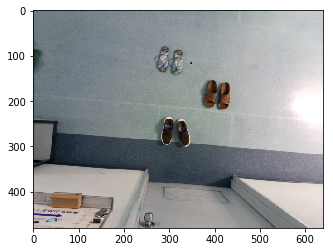

In [21]:
#input input img
filepath = "data/2_sss_data/shoesSamples/forTest/open_campus/9_45_59.png"
img = cv2.imread(filepath)
if img is None:
    print "cannot read image"
X = format_img(img, C)
# img_scaled = np.transpose(X.copy()[0, (2, 1, 0), :, :], (1, 2, 0)).copy()
# img_scaled[:, :, 0] += 123.68
# img_scaled[:, :, 1] += 116.779
# img_scaled[:, :, 2] += 103.939

img_input = img.astype(np.uint8)

import matplotlib.pyplot as plt

plt.imshow(img_input, cmap = 'gray')
plt.show()

In [31]:
from keras import backend as K

layer_name = 'block5_conv3'
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
print layer_output

loss = K.mean(layer_output[:, :, :, filter_index])
print loss

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, img_input)[0]
print "grads="
print grads
# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])


Tensor("block5_conv3_2/Relu:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("Mean_29:0", shape=(), dtype=float32)
grads=
[None]


TypeError: Expected binary or unicode string, got None

In [ ]:
import numpy as np

# we start from a gray image with some noise
input_img_data = np.random.random((1, 3, img_width, img_height)) * 20 + 128.
# run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [ ]:
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
img = deprocess_image(img)
imsave('%s_filter_%d.png' % (layer_name, filter_index), img)
